# Analyzing COVID-19 Papers

In this challenge, we will continue with the topic of COVID pandemic, and focus on processing scientific papers on the subject. There is [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) with more than 7000 (at the time of writing) papers on COVID, available with metadata and abstracts (and for about half of them there is also full text provided).

A full example of analyzing this dataset using [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) cognitive service is described [in this blog post](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). We will discuss simplified version of this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Getting the Data

First, we need get the metadata for CORD papers that we will be working with.

**NOTE**: We do not provide a copy of the dataset as part of this repository. You may first need to download the [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) file from [this dataset on Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registration with Kaggle may be required. You may also download the dataset without registration [from here](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), but it will include all full texts in addition to metadata file.

We will try to get the data directly from online source, however, if it fails, you need to download the data as described above. Also, it makes sense to download the data if you plan to experiment with it further, to save on waiting time.

> **NOTE** that dataset is quite large, around 1 Gb in size, and the following line of code can take a long time to complete! (~5 mins)

In [2]:
# df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
df = pd.read_csv("metadata.csv")
df.head()

C:\Users\magsa\AppData\Local\Temp\ipykernel_25260\1405502695.py:2: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("metadata.csv")


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


We will now convert publication date column to `datetime`, and plot the histogram to see the range of publication dates.

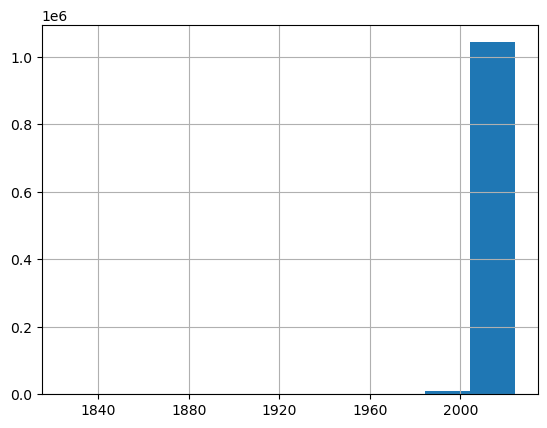

In [3]:
df['publish_time'] = pd.to_datetime(df['publish_time'], format = 'mixed')
df['publish_time'].hist()
plt.show()

Interestingly, there are coronavirus-related papers that date back to 1880!

## Structured Data Extraction

Let's see what kind of information we can easily extract from abstracts. One thing we might be interested in is to see which treatment strategies exist, and how they evolved over time. To begin with, we can manually compile the list of possible medications used to treat COVID, and also the list of diagnoses. We then go over them and search corresponding terms in the abstracts of papers.

In [4]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


In [5]:
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,heparin,favipiravir,methylprednisolone,covid,sars,pneumonia,infection,diabetes,coronavirus,death
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,0,0,0,0,0,10,6,0,0,0
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,0,0,0,0,0,0,0,0,0,0
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,0,0,0,0,0,0,0,0,0,0
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,0,0,0,0,0,0,0,0,0,0
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,0,0,0,0,0,1,2,0,0,0


We have added a bunch of columns to our dataframe that contain number of times a given medicine/diagnosis is present in the abstract. 

> **Note** that we add space to the beginning of the word when looking for a substring. If we do not do that, we might get wrong results, because *chloroquine* would also be found inside substring *hydroxychloroquine*. Also, we force conversion of abstracts column to `str` to get rid of an error - try removing `str` and see what happens.

To make working with data easier, we can extract the sub-frame with only medication counts, and compute the accumulated number of occurrences. This gives is the most popular medication: 

In [6]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

,Name,Count
0,hydroxychloroquine,11157
3,remdesivir,10680
2,tocilizumab,7914
8,heparin,5563
1,chloroquine,5222
7,dexamethasone,5110
4,azithromycin,4352
5,lopinavir,4315
9,favipiravir,3358
10,methylprednisolone,2346


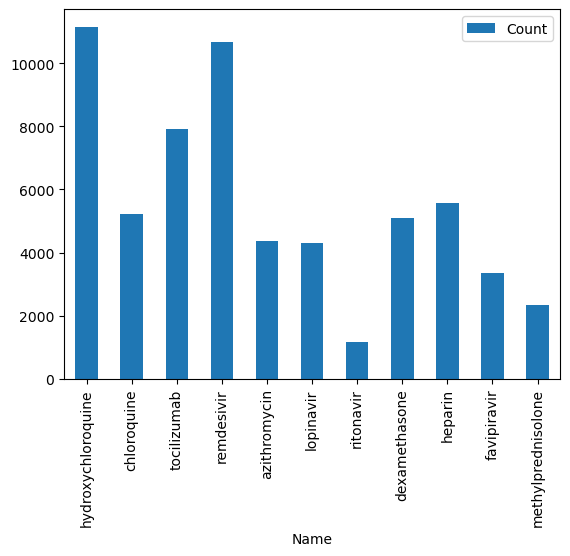

In [7]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Looking for Trends in Treatment Strategy

In the example above we have `sum`ed all values, but we can also do the same on a monthly basis:

In [8]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3885         1976         1911   
             2                              0           19            0   
             3                             46           73            5   
             4                            186          236           49   
             5                            450          188          158   
             6                            381          149          243   
             7                            379          176          204   
             8                            313          115          175   
             9                            318          124          188   
             10                           311           96          210   
             11                           267           66          169   
             12                           254          108          228   
2021         1                           2467          882         2165   
             2                            165           66          184   
             3                            175           86          189   
             4                            200           71          129   
             5                            152           55          139   
             6                            144           30          146   
             7                            115           45           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2280          1226       1549        403   
             2                      3             3         18         11   
             3                     29            12         52         16   
             4                    122            69        113         13   
             5                    209           128        134         41   
             6                    186           110        132         18   
             7                    174           108        138         29   
             8                    173           148         93         24   
             9                    190            90         97         28   
             10                   227            93        126         39   
             11                   202            77        106         27   
             12                   267            98         75         30   
2021         1                   2877          1072        932        216   
             2                    180            90         76          9   
             3                    301            89        101         18   
             4                    167            89         60         13   
             5                    182            71         56         22   
             6                    180            75         47         14   
             7                    252            83         52          4   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       598     1027          730   
             2                         1        3           12   
             3                         3       18           11   
             4                        14       80           48   
             5                        12       93           48   
             6                        48       84           30   
             7                        58      116           56   
             8                        56       96           46   
             9                        90      113           46   
             10                      101      117           82   
             11                       84 

This gives us a good picture of treatment strategies. Let's visualize it!

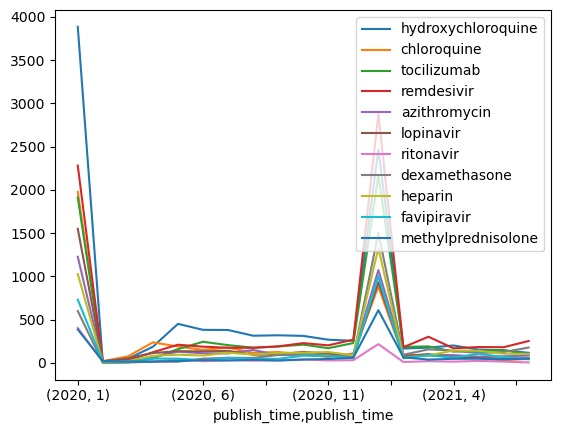

In [9]:
dfmt.plot()
plt.show()

An interesting observation is that we have huge spikes at two locations: January, 2020 and January, 2021. It is caused by the fact that some papers do not have a clearly specified data of publication, and they are specified as January of the respective year.

To make more sense of the data, let's visualize just a few medicines. We will also "erase" data for January, and fill it in by some medium value, in order to make nicer plot:

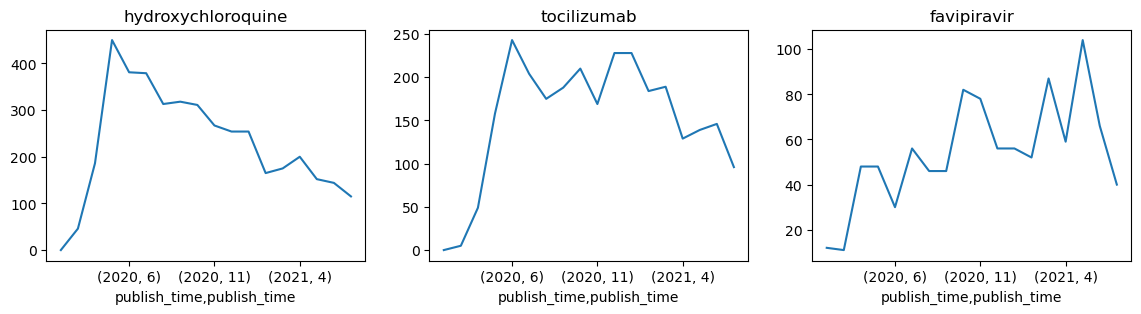

In [10]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(14,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Observe how popularity of hydroxychloroquine was on the rise in the first few months, and then started to decline, while number of mentions of favipiravir shows stable rise. Another good way to visualize relative popularity is to use **stack plot** (or **area plot** in Pandas terminology):

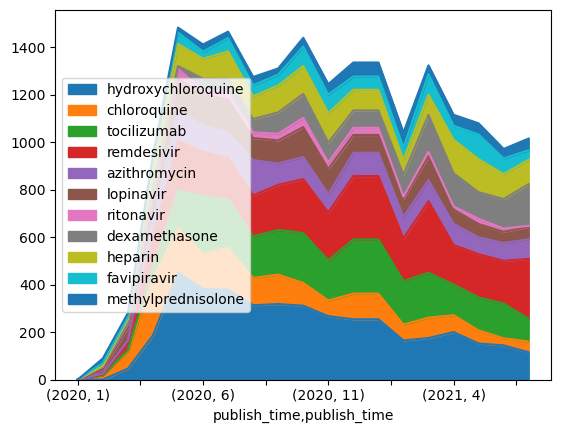

In [11]:
dfmt.plot.area()
plt.show()

Even further, we can compute relative popularity in percents:

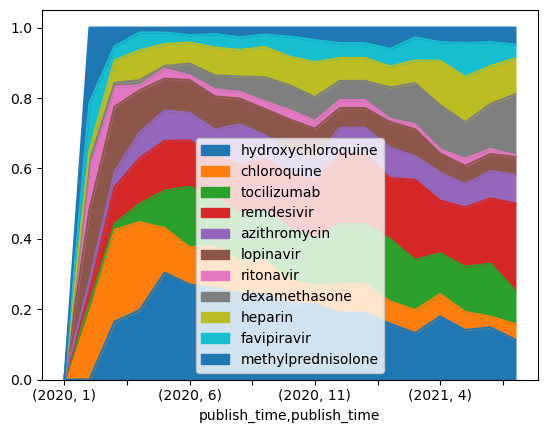

In [12]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()


## Computing Medicine-Diagnosis Correspondence

One of the most interesting relationships we can look for is how different diagnoses are treated with different medicines. In order to visualize it, we need to compute **co-occurence frequency map**, which would show how many times two terms are mentioned in the same paper.

Such a map is essentially a 2D matrix, which is best represented by **numpy array**. We will compute this map by walking through all abstracts, and marking entities that occur there:

In [13]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [14]:
m

array([[5470., 2585.,  812., 2381.,  387., 3036., 1081.],
       [2376., 1381.,  258., 1077.,   90., 1555.,  408.],
       [2738., 1007.,  833., 1343.,  236., 1333.,  678.],
       [4284., 2804.,  720., 2076.,  241., 2677.,  817.],
       [2163.,  928.,  476., 1066.,  180., 1032.,  481.],
       [2244., 1239.,  424.,  976.,  122., 1495.,  406.],
       [ 594.,  429.,   87.,  301.,   23.,  409.,  123.],
       [2164.,  919.,  521., 1113.,  180., 1019.,  463.],
       [2035.,  877.,  428.,  999.,  137.,  996.,  365.],
       [1257.,  791.,  250.,  565.,   55.,  804.,  173.],
       [1008.,  476.,  399.,  574.,  100.,  582.,  205.]])

One of the ways to visualize this matrix is to draw a **heatmap**:

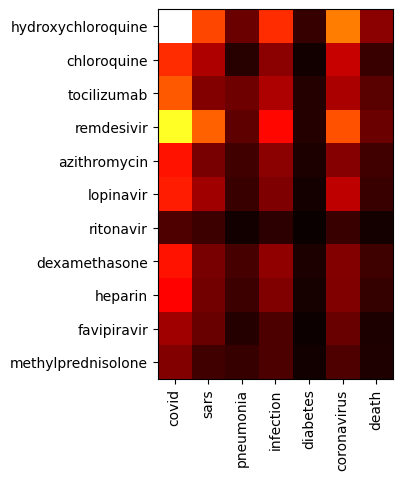

In [15]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

However, even better visualization can be done using so-called **Sankey** diagram! `matplotlib` does not have built-in support for this diagram type, so we would have to use [Plotly](https://plotly.com/python/) as described [in this tutorial](https://plotly.com/python/sankey-diagram/).

To make plotly sankey diagram, we need to build the following lists:
* List `all_nodes` of all nodes in the graph, which will include both medications and diagnosis
* List of source and target indices - those lists would show, which nodes go to the left, and which to the right part of the diagram
* List of all links, each link consisting of:
   - Source index in the `all_nodes` array
   - Target index 
   - Value indicating strength of the link. This is exactly the value from our co-occurence matrix.
   - Optionally color of the link. We will make an option to highlight some of the terms for clarity

Generic code to draw sankey diagram is structured as a separate `sankey` function, which takes two lists (source and target categories) and co-occurence matrix. It also allows us to specify the threshold, and omit all links that are weaker than that threshold - this makes the diagram a little bit less complex. 

In [16]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusion

You have seen that we can use quite simple methods to extract information from non-structured data sources, such as text. In this example, we have taken the existing list of medications, but it would be much more powerful to use natural language processing (NLP) techniques to perform entity extraction from text. In [this blog post](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) we describe how to use cloud services for entity extraction. Another option would be using Python NLP libraries such as [NLTK](https://www.nltk.org/) - an approach for extracting information from text using NLTK is described [here](https://www.nltk.org/book/ch07.html).

## Challenge

Continue to research the COVID paper data along the following lines:

1. Build co-occurrence matrix of different medications, and see which medications often occur together (i.e. mentioned in one abstract). You can modify the code for building co-occurrence matrix for medications and diagnoses.
1. Visualize this matrix using heatmap.
1. As a stretch goal, you may want to visualize the co-occurrence of medications using [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [This library](https://pypi.org/project/chord/) may help you draw a chord diagram.
1. As another stretch goal, try to extract dosages of different medications (such as **400mg** in *take 400mg of chloroquine daily*) using regular expressions, and build dataframe that shows different dosages for different medications. **Note**: consider numeric values that are in close textual vicinity of the medicine name.

### 1. Co-occurrence matrix of differemt medications

In [17]:
m = np.zeros((len(medications),len(medications)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(medications):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if i != j and ' '+me in x:
                    m[j,i] += 1

m

array([[   0., 1657.,  684., 1224., 1593., 1194.,  284.,  305.,  144.,
         545.,  117.],
       [1657.,    0.,  219.,  743.,  506.,  655.,  200.,  123.,   34.,
         338.,   18.],
       [ 684.,  219.,    0.,  594.,  304.,  396.,   89.,  316.,  110.,
         216.,  175.],
       [1224.,  743.,  594.,    0.,  393.,  911.,  246.,  821.,  147.,
         680.,  100.],
       [1593.,  506.,  304.,  393.,    0.,  449.,  106.,  188.,   93.,
         196.,   89.],
       [1194.,  655.,  396.,  911.,  449.,    0.,  547.,  156.,   48.,
         455.,   71.],
       [ 284.,  200.,   89.,  246.,  106.,  547.,    0.,   45.,   23.,
         113.,   16.],
       [ 305.,  123.,  316.,  821.,  188.,  156.,   45.,    0.,  142.,
         129.,  208.],
       [ 144.,   34.,  110.,  147.,   93.,   48.,   23.,  142.,    0.,
          49.,   57.],
       [ 545.,  338.,  216.,  680.,  196.,  455.,  113.,  129.,   49.,
           0.,   42.],
       [ 117.,   18.,  175.,  100.,   89.,   71.,   16.,  20

### 2. Visualize this matrix using heatmap.

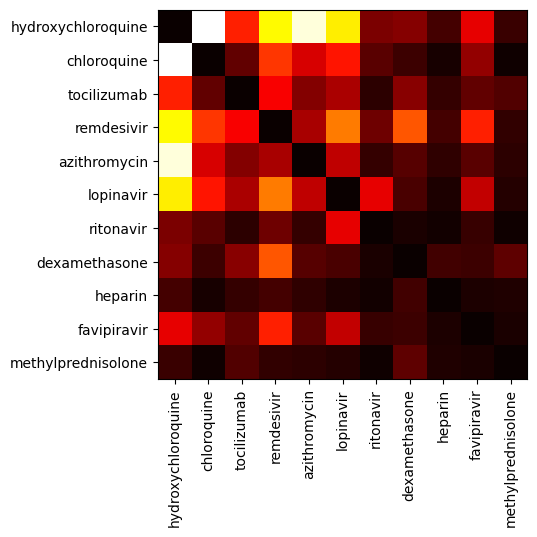

In [18]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(medications)))
ax.set_xticklabels(medications,rotation=90)
plt.show()

### 3. Visualize the co-occurrence of medications using chord diagram

In [19]:
from plotapi import Chord
m = m.tolist()

Chord(m, medications).show()

Exception: {'reason': 'Authentication failed. Please check your license details or get one from https://plotapi.com.'}

Since the chord digram require payment I decided to use the sankey diagram instead.

In [77]:
sankey(medications, medications, m, h2= [0])

### 4. Try to extract dosages of different medications (such as **400mg** in *take 400mg of chloroquine daily*) using regular expressions, and build dataframe that shows different dosages for different medications. 
**Note**: consider numeric values that are in close textual vicinity of the medicine name.

This calls a model from **Hugging Face** trained to find dosage and medication etc. called **Med7**. This is more accurate than RegEx but still not perfect at finding the combination of dose and medication. It is also much more computationally expensive than RegEx.

In [152]:
import requests
import json
import time

# Enter your HuggingFace API token
API_TOKEN = input("Enter your HuggingFace API token: ")

API_URL = "https://api-inference.huggingface.co/models/kormilitzin/en_core_med7_trf"
headers = {"Authorization": f"Bearer {API_TOKEN}"}

df["analysis"] = "" 


def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

for index, row in test_df.iterrows():
    text = row['abstract']
    time.sleep(10) 
    output = query(text)
    
    test_df.at[index, 'analysis'] = output

print(test_df['analysis'])

420858                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [151]:
#Sample that has a covid value greater than 0
test_df = df.sample(n=10000).loc[df['hydroxychloroquine'] > 0]


In [173]:
#drop row [1:15]
test_df.head()


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,favipiravir,methylprednisolone,covid,sars,pneumonia,infection,diabetes,coronavirus,death,analysis
420858,ceh43kdw,NaN,WHO,Drug Repurposing Strategy (DRS): Emerging Appr...,NaN,NaN,NaN,unk,Drug repurposing is also termed as drug reposi...,2021-01-01,...,1,0,4,0,0,1,0,2,0,"[{'entity_group': 'DRUG', 'word': 'angiotensin..."
341477,g6irn9lw,NaN,WHO,Azithromycin in COVID-19 Patients: Pharmacolog...,NaN,NaN,NaN,unk,The global COVID-19 pandemic has led to a race...,2020-01-01,...,0,0,5,0,1,0,0,0,0,"[{'entity_group': 'DRUG', 'word': 'Azithromyci..."
340233,6fnowwxu,NaN,WHO,Brief Report: Hydroxychloroquine does not indu...,NaN,NaN,NaN,unk,BACKGROUND: Hydroxychloroquine (HCQ) is widely...,2020-01-01,...,0,0,1,0,0,0,0,0,0,"[{'entity_group': 'DRUG', 'word': 'Hydroxychlo..."
327631,lm53wsb5,NaN,WHO,COVID-19 pneumonia in patients with hematologi...,NaN,NaN,NaN,unk,Background: Limited data are available for ris...,2020-01-01,...,0,1,3,0,1,0,1,0,0,"[{'entity_group': 'DRUG', 'word': 'chemotherap..."
468146,muvuzl11,NaN,WHO,"Treatment with hydroxychloroquine, azithromyci...",NaN,NaN,NaN,unk,SIGNIFICANCE: The United States is in an accel...,2020-01-01,...,0,0,5,1,0,0,0,0,0,"[{'entity_group': 'DRUG', 'word': 'hydroxychlo..."


In [174]:


drugs_strengths = []


for entities in test_df['analysis']:
    extracted_words = []
    for entity in entities:
        if entity['entity_group'] in ['STRENGTH', 'DOSAGE']:
            extracted_words.append(entity['word'])
    drugs_strengths.append(extracted_words)

print(drugs_strengths)

[[], [], ['high-dose', 'high-dose'], ['0', '5mg/kg'], [], [], [], [], [], [], [], ['400 mg/d'], [], [], [], ['high dose'], [], [], [], [], [], [], [], [], [], [], [], ['400 mg', '100 mg', '400 mg', '400 mg', '200 mg', '100 mg'], [], [], ['658', '660', '150', '330'], [], [], [], [], [], [], [], [], ['30 mg/kg/day', '2 mg/kg/day'], []]
